# Vorverarbeitung: Entfernen von Bildern, welche unter- oder überbelichtet sind

## Einleitung

Einige der Bildaufnahmen waren überbelichtet oder unterbelichtet. Dies kam vor, wenn sich die Lichtverhältnisse der Umgebung schnell änderten. Wenn z.B. die Sonne zwischen Bäumen schien, dann konnten Bilder entstehen, die überbelichtet waren. Bei der Fahrt in einem Tunnel konnten wiederum Bilder unterbelichtet sein. Die Belichtungszeit wurde automatisch berechnet mit der Android Camera2 API. Bevor ein Bild zur weiteren Verarbeitung aufgenommen wurde, wurde überprüft mit einer Probeaufnahme, ob die Belichtungszeit Parameter gut waren. Das Ergebnis der Aufnahme muss für eine brauchbares Ergebnis gleich dem Zustand CaptureResult.CONTROL\_AE\_STATE\_CONVERGED sein. Es gibt keine Garantie, dass bei der nächsten Bildaufnahme die Belichtungszeit noch korrekt eingestellt ist. 


Warum wurde die Belichtungszeit dann nicht manuell eingestellt? Das Ziel ist es möglichst Bilder mit einer kurzen Belichtungszeit ohne großer Bewegungsschärfe zu erfassen. Dafür wurde in der App die Belichtungszeit Bildrate CaptureRequest.CONTROL\_AE\_TARGET\_FPS\_RANGE auf $30$ Bilder pro Sekunde eingestellt. Der Kamera Szenenmodus wurde auf Action für bewegende Objekte ausgewählt. Die Belichtungszeit statisch manuell festzulegen ist kompliziert, weil damit auch der ISO Wert und die Bildrate mit angegeben werden muss. Die Lichtverhältnisse während der fahrt ändern sich und mit einer festen Belichtungszeit können ganze Bildreichen unter oder überbelichtet werden.

In diesem Jupyter Notebook ging es darum die entsprechenden unter oder überbelichteten Bilder aus einem Datensatz zu entfernen.

## Versuchsbeschreibung 

Für einen Datensatz wurden alle zugeschnittenen Bilder in ein Python Programm geladen. Dann wurde das Histogramm siehe G. 1 der Grauwerte berechnet. Dabei entspricht $g$ ein Grauwert und $n_g$ die Anzahl der Bildpunkte mit diesem Grauwert. 

$$
h(g) = n_g
$$ <div style="text-align: right"><i>(1)</i></div>

$$
\mu = \frac{\sum \limits_{i=0}^n g_i * h(g_i)}{\sum \limits_{i=0}^n * h(g_i)}
$$ <div style="text-align: right"><i>(2)</i></div>

Als nächstes wurde der Mittelwert $\mu$ siehe G. 2 der Grauwerte also die Summe aller Grauwerte durch die Anzahl der Bildpunkte für jedes Bild berechnet werden. Ein Grenzwert wurde dann ausgewählt, um zu entscheiden ob ein Bild unter oder überbelichtet ist. Falls dies für ein Bild zutrifft wurde dieses sowie die dazugehörigen Einträge in der merkmale.csv Datei gelöscht.

## Versuchsdurchführung

Auf der Abb. 1} sind überbelichtet Bilder zu sehen aus dem Datensatz 41. Beispiele für unterbelichtete Bilder sind auf Abb. 2 zu sehen. Als oberer und unterer Schwellwert wurden die obersten und untersten $\approx19,5\%$ für $\mu$ ausgewählt siehe G. 3. Ein Bild gilt demnach als überbelichtet, wenn der Mittelwert der Grauwerte größer als der Grauwert 204 ist. Dann ist ein Bild unterbelichtet bei einem mittleren Grauwert von kleiner als 50. Für den Datensatz 41 traf dies auf $0,69\%$ der Bildaufnahmen zu. Hierbei existieren 5940 Bilder insgesamt für diesen Datensatz.  

$$p=\frac{100*W}{G} \Rightarrow p=\frac{100*50}{256}=19,53125\%$$
<div style="text-align: right"><i>(3)</i></div>

<img src='../daten/abbildungen/ueberbelichteteBilderDatensatz41.png' alt='ueberbelichteteBilderDatensatz41.png'></img>
Abbildung 1: Beispiele von überbelichteten Bildern aus dem Datensatz 41 

<img src='../daten/abbildungen/unterbelichteteBilderDatensatz41.png' alt='unterbelichteteBilderDatensatz41.png'></img>
Abbildung 2: Beispiele von unterbelichteten Bildern aus dem Datensatz 41 

Der Prozentsatz der Bilder die unter- oder überbelichtet ist beträgt für die Datensätze 37 bis 42 gleich $0,088\%$.

## Ergebnis

Wie auf Abb. 1 und 2 zu sehen ist mit der Berechnung des Mittelwertes G. 2 eine Einteilung der Bilder in unter- bzw. überlichtete und normal Belichtete Aufnahmen möglich. Ein Nachteil bei diesem Ansatz ist das alle Grauwerte betrachtet wurden. Eine störende Belichtung in einem kleinem Bildbereich wurde somit nicht ermittelt.  

In [1]:
import os
import pandas
import cv2
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
# Name des Datensatzes
numberDataset = '41'

In [5]:
featuresDf = pandas.read_csv("../daten/merkmale_datensatz_" +  numberDataset  + "/merkmale.csv")

In [11]:
# Hier können die Datensätze ausgewählt werden
datasets = ["41"]
# Die Pfade zu den Ordnern in welchem sich die Bilder befinden
paths = []
# Pfad und Name der Bilder
imagePaths = []

In [12]:
for dataset in datasets: # Für jeden Datensatz merke Pfad
    paths.append("E:/bachelor/daten/" + dataset + "/zugeschnitten_fuer_abb/")
for path in paths: # Für jeden Pfad hole die Namen der Ordner
    folders = os.listdir(path)
    folders = sorted(folders, key=int) #sortiert die Reihenfolge de Ordner aufsteifend
    print("Bilder aus folgenden Ordnern werden geladen: " + str(folders))
    for folder in folders: # Aus der Liste der Ordner wird ein Ordner ausgewählt
        filesPath = path + folder + "/"
        files = os.listdir(filesPath)
        print("Ordner der geladen wird: " + str(folder))
        for name in files: # Ein Dateiname aus diesem Ordner
            if "jpg" not in name:
                continue
            imagePaths.append(filesPath + name) # Pfad zu den Bild wird zur Liste mit Pfaden hinzugefügt

Bilder aus folgenden Ordnern werden geladen: ['1', '2', '3']
Ordner der geladen wird: 1
Ordner der geladen wird: 2
Ordner der geladen wird: 3


In [13]:
len(imagePaths)

5940

In [ ]:
# Überprüfung ob der Bild Zeitstempel mit den Zeitstempel von den Merkmalen übereinstimmt
index = 120
print("Pfad zu den Bild: " + str(imagePaths[index]))
print("Zeitstempel in UTC: " + str(featuresDf.iloc[index]['Zeitstempel in Unixzeit']))

In [14]:
len(imagePaths)

5940

In [ ]:
featuresDf.iloc[index]

In [ ]:
# Für ein einzelnes Bild wird das Histogramm geplottet
img = images[1]
plt.figure(figsize=(8,8))
plt.xlabel('Bildpunkte x')
plt.ylabel('Bildpunkte y')
plt.imshow(img, cmap='gray')

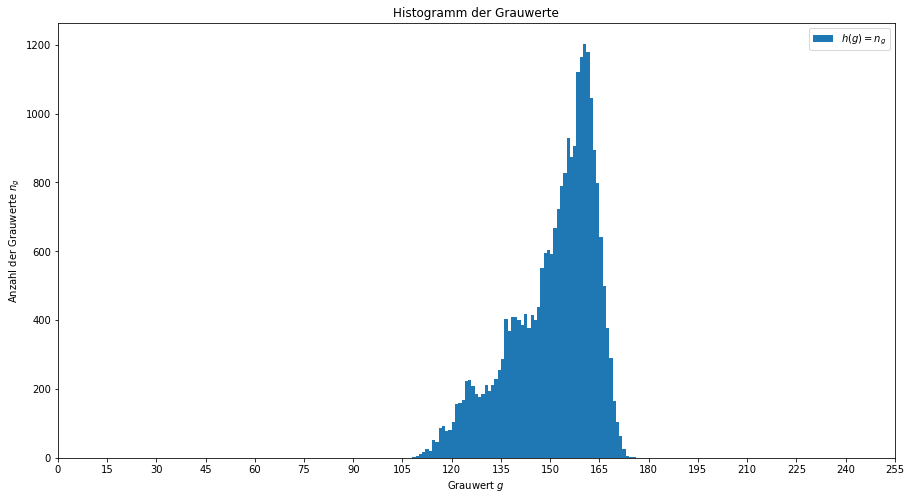

In [257]:
plt.figure(figsize=(15,8))
plt.hist(img.ravel(),256,[0,256], label="$h(g) = n_g$")
plt.title('Histogramm der Grauwerte')
plt.xlabel('Grauwert $g$')
plt.ylabel('Anzahl der Grauwerte $n_g$')
plt.xlim(0,255)
plt.xticks(np.arange(0.0, 255.01, 15.0))
plt.legend()

In [258]:
imgFlat = img.ravel() # Array von 2D auf 1D konvertieren

In [259]:
imgFlat.sum() / imgFlat.size # Berechnung des Mittelswert

150.41909937888198

In [17]:
# Berechne Indexe für Bilder die unter oder überbelichtet sind
indexe = []
imagePathsToDelete = [] # String Pfade zu den Bildern welche gelöscht werden 
i = 0
upperThreshold = 204 # obere Grauwert Schwelltwert für überbelichtete Bilder
lowerThreshold = 50  # unterer Grauwert Schwellwert für unterbelichtete Bilder
for path in imagePaths:
    img  = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2GRAY)
    img = img.astype('float32')
    imgFlat = img.ravel()
    mean = imgFlat.sum() / imgFlat.size
    if mean > upperThreshold or mean < lowerThreshold:
        indexe.append(i)
        imagePathsToDelete.append(imagePaths[i])
    i = i + 1

In [18]:
indexe

[41,
 64,
 156,
 246,
 363,
 504,
 725,
 816,
 1005,
 1060,
 1071,
 1138,
 1351,
 1456,
 1476,
 1660,
 1669,
 2021,
 2098,
 2372,
 2471,
 2862,
 2886,
 2944,
 3139,
 3489,
 3490,
 3655,
 3696,
 3897,
 3947,
 4007,
 4089,
 4436,
 4721,
 4897,
 4912,
 5057,
 5178,
 5196,
 5199,
 5226,
 5228,
 5305,
 5330,
 5402,
 5428,
 5454,
 5475,
 5545,
 5558,
 5617,
 5666,
 5726,
 5732]

In [208]:
# Berechne die Prozentzahl der Bilder die unter- oder überbelichtet sin p = W/G
(np.asarray(indexe).shape[0] / np.asarray(images).shape[0]) * 100 

0.016130766749112808

In [209]:
(np.asarray(indexe).shape[0])

3

161.45652173913044

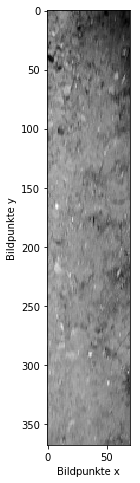

In [167]:
img = images[5617]
plt.figure(figsize=(8,8))
plt.xlabel('Bildpunkte x')
plt.ylabel('Bildpunkte y')
plt.imshow(img, cmap='gray')
imgFlat = img.ravel()
imgFlat.sum() / imgFlat.size

In [30]:
overexposedImg = []
underexposedImg = []
for index in indexe:
    img  = cv2.cvtColor(cv2.imread(imagePaths[index]),cv2.COLOR_BGR2GRAY)
    img = img.astype('float32')
    imgFlat = img.ravel()
    mean = imgFlat.sum() / imgFlat.size
    if mean > upperThreshold:
        overexposedImg.append(img)
    if mean < lowerThreshold:
        underexposedImg.append(img)

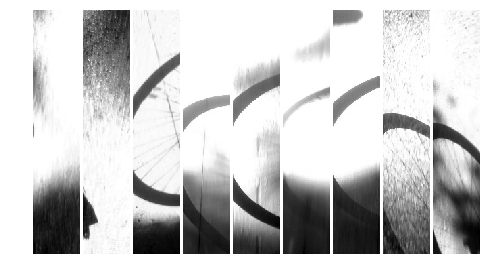

In [41]:
# Beispiele für überbelichtete Bilder
fig = plt.figure(1,figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 9), axes_pad=0.05)
imageToShow = 9
for i, img in enumerate(overexposedImg[0: imageToShow]):
    ax = grid[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.grid(False)
plt.title('Überbelichtete Bilder aus Datensatz ' + str(numberDataset))
plt.savefig('ueberbelichteteBilderDatensatz' + str(numberDataset),dpi=300)

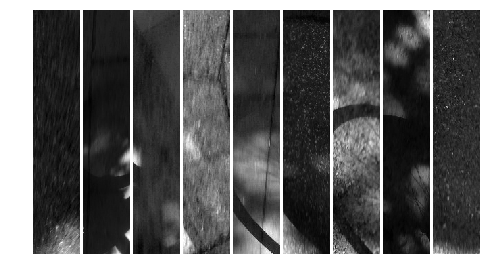

In [42]:
# Beispiele für unterbelichtete Bilder
fig = plt.figure(1,figsize=(8,8))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 9), axes_pad=0.05)
imageToShow = 9
for i, img in enumerate(underexposedImg[0: imageToShow]):
    ax = grid[i]
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.title('Unterbelichtete Bilder aus Datensatz ' + str(numberDataset))
plt.savefig('unterbelichteteBilderDatensatz' + str(numberDataset),dpi=300)

Anhand der gefundenen Indices können Bilder, welche unter- oder überbelichtet sind gelöscht werden.
Dazu müssen die Merkmale wie Messwerte aus den CSV Dateien entfernt werden. Bei der Ausführung der folgenden Zeilen ist darauf zu achten nicht ausversehen falsche Daten zu löschen.

In [171]:
# merkmaleRoh.csv Zeilen mit gefundenen Index löschen
featuresDf.drop(indexe, inplace=True)
# Die Inecies müssen zurückgesetzt werden nach den Aufruf von drop. Ansonsten kommte es zu KeyValue Fehlern
featuresDf.reset_index(drop=True,inplace=True)
featuresDf.to_csv('../daten/merkmale_datensatz_'+ dataset + '/merkmaleRoh.csv')

In [ ]:
# merkmale.csv Zeilen mit gefundenen Index löschen
#featuresDf = pandas.read_csv("../daten/merkmale_datensatz_" +  numberDataset  + "/merkmale.csv")
#featuresDf.drop(indexe, inplace=True)
# Die Inecies müssen zurückgesetzt werden nach den Aufruf von drop. Ansonsten kommte es zu KeyValue Fehlern
#featuresDf.reset_index(drop=True,inplace=True)
#featuresDf.to_csv('../daten/merkmale_datensatz_'+ dataset + '/merkmale.csv')

In [197]:
# nickMesswerte.csv Zeilen mit gefundenen Index löschen
#pitchsDf = pandas.read_csv("../daten/merkmale_datensatz_" +  numberDataset  + "/nickMesswerte.csv")
#pitchsDf.set_index('index', inplace=True)
#pitchsDf.drop(indexe, inplace=True)
#pitchsDf.to_csv('../daten/merkmale_datensatz_'+ dataset + '/nickMesswerte.csv')

In [198]:
# zAchseBeschleunigungswerte.csv Zeilen mit gefundenen Index löschen
#accZDf = pandas.read_csv("../daten/merkmale_datensatz_" +  numberDataset  + "/zAchseBeschleunigungswerte.csv")
#accZDf.set_index('index', inplace=True)
#accZDf.drop(indexe, inplace=True)
#accZDf.to_csv('../daten/merkmale_datensatz_'+ dataset + '/zAchseBeschleunigungswerte.csv')

In [199]:
# yAchseBeschleunigungswerte.csv
#accYDf = pandas.read_csv("../daten/merkmale_datensatz_" +  numberDataset  + "/yAchseBeschleunigungswerte.csv")
#accYDf.set_index('index', inplace=True)
#accYDf.drop(indexe, inplace=True)
#accYDf.to_csv('../daten/merkmale_datensatz_'+ dataset + '/yAchseBeschleunigungswerte.csv')

In [200]:
# sensoreventZeitstempel.csv
#sensorEventTimestampsDf = pandas.read_csv("../daten/merkmale_datensatz_" +  numberDataset  + "/sensoreventZeitstempel.csv")
#sensorEventTimestampsDf.set_index('index', inplace=True)
#sensorEventTimestampsDf.drop(indexe, inplace=True)
#sensorEventTimestampsDf.to_csv('../daten/merkmale_datensatz_'+ dataset + '/sensoreventZeitstempel.csv')

In [17]:
# Entfernt zugeschnitte Bilder aus den Datensatz
for img in imagePathsToDelete:
    print(img)
    os.remove(img)
imagePathsToDelete.clear

E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/1/1530618579541.jpg
E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/1/1530618615928.jpg
E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/1/1530618652371.jpg
E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/1/1530618659684.jpg
E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/1/1530618671910.jpg
E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/1/1530618672621.jpg
E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/1/1530618696329.jpg
E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/1/1530618809197.jpg
E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/1/1530618863447.jpg
E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/1/1530618871914.jpg
E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/1/1530618874066.jpg
E:/bachelor/daten/51/zugeschnitten_passendFuerVortrainiertesNetz/

<function list.clear>